In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
import torch
device = torch.device("cuda") #set pytorch to be used on GPU

In [3]:
print(torch.__version__)

1.7.1


In [4]:
import transformers

In [5]:
import os
# from google.colab import drive

# Mount google drive
DRIVE_MOUNT='./'
# drive.mount(DRIVE_MOUNT)

# create folder to write data to
DLNLP_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'DLNLP_2020')
HOMEWORK_FOLDER=os.path.join(DLNLP_FOLDER, 'Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [6]:
x_train = pd.read_csv(HOMEWORK_FOLDER+'/training_data.csv')
x_test = pd.read_csv(HOMEWORK_FOLDER+'/testing_data.csv')
y_train = pd.read_csv(HOMEWORK_FOLDER+'/train_labels.csv')
y_test = pd.read_csv(HOMEWORK_FOLDER+'/test_labels.csv')

In [7]:
x_train.drop(columns=['Unnamed: 0'], inplace = True)
x_test.drop(columns=['Unnamed: 0'], inplace = True)
y_train.drop(columns=['Unnamed: 0'], inplace = True)
y_test.drop(columns=['Unnamed: 0'], inplace = True)

In [8]:
fake = pd.read_csv(HOMEWORK_FOLDER+'/fakeForModeling.csv')
true = pd.read_csv(HOMEWORK_FOLDER+'/trueForModeling.csv')

In [9]:
fake.drop(columns=['Unnamed: 0'], inplace = True)
true.drop(columns=['Unnamed: 0'], inplace = True)

# Binomial Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

# 2. instantiate a logistic regression model
lr = LogisticRegression()

lr.fit(x_train, np.ravel(y_train))

LogisticRegression()

In [11]:
y_pred_lr = lr.predict(x_test)

In [12]:
print ("Accuracy is: ", metrics.accuracy_score(y_test, y_pred_lr))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Accuracy is:  0.8973170994504902
Mean Squared Error is: 0.32044172722900766


In [13]:
lr_cm = metrics.confusion_matrix(y_test, y_pred_lr)
print (lr_cm)

[[3984  501]
 [ 452 4344]]


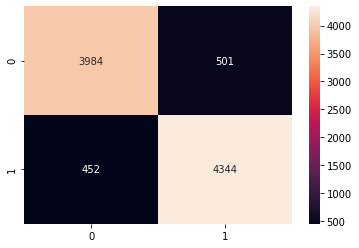

In [15]:
labels = np.array(lr_cm)
sns.heatmap(lr_cm, annot=labels, fmt = '')
plt.show()

In [16]:
print(metrics.classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4485
           1       0.90      0.91      0.90      4796

    accuracy                           0.90      9281
   macro avg       0.90      0.90      0.90      9281
weighted avg       0.90      0.90      0.90      9281



In [17]:
# Calculate predicted probabilities for test data 
y_pred_prob_lr = lr.predict_proba(x_test)[:, 1]

In [18]:
metrics.roc_auc_score(y_test, y_pred_prob_lr)

0.9547588895614425

# Naive Bayes

In [19]:
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()# one of the two classic naive Bayes variants used in text classification

%time nb.fit(x_train, np.ravel(y_train))

CPU times: user 56.4 ms, sys: 6.53 ms, total: 62.9 ms
Wall time: 31.4 ms


MultinomialNB()

In [20]:
y_pred_class = nb.predict(x_test)

In [21]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_class))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_class)))

Accuracy is: 0.8684409007650038
Mean Squared Error is: 0.3627107652593127


In [22]:
nb_cm = metrics.confusion_matrix(y_test, y_pred_class)
print(nb_cm)

[[3872  613]
 [ 608 4188]]


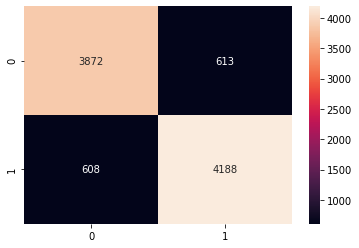

In [23]:
labels =  np.array(nb_cm)
sns.heatmap(nb_cm, annot=labels, fmt = '')
plt.show()

In [24]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4485
           1       0.87      0.87      0.87      4796

    accuracy                           0.87      9281
   macro avg       0.87      0.87      0.87      9281
weighted avg       0.87      0.87      0.87      9281



In [25]:
# Calculate predicted probabilities for test data 
y_pred_prob_nb = nb.predict_proba(x_test)[:, 1]

In [26]:
metrics.roc_auc_score(y_test, y_pred_prob_nb)

0.9333181776340931

In [27]:
#Number of times token appears in each True article
true_token = nb.feature_count_[0, :]

#Number of times token appears in each Fake article
fake_token = nb.feature_count_[1, :]

In [28]:
tokens = pd.DataFrame({'token':x_train.columns, 'true':true_token, 'fake':fake_token}).set_index('token')
tokens.head()

,true,fake
token,,
according,384.828061,394.890371
act,218.300525,275.816121
action,286.925843,277.689188
added,318.648536,161.806045
administration,500.333563,363.236312


In [29]:
# add 1 to true and fake counts to avoid dividing by 0
tokens['true'] = tokens.true + 1
tokens['fake'] = tokens.fake + 1

In [30]:
# convert the true and fake counts into frequencies
tokens['true'] = tokens.true / nb.class_count_[0]
tokens['fake'] = tokens.fake / nb.class_count_[1]

In [31]:
# calculate the ratio of fake to true for each token
tokens['fake/true ratio'] = tokens.fake / tokens.true
tokens.sort_values('fake/true ratio', ascending=False).head(10)

,true,fake,fake/true ratio
token,,,
video,0.005443,0.039229,7.207080
fact,0.004219,0.025490,6.041735
hillary,0.008842,0.048001,5.428504
really,0.004868,0.025361,5.209811
know,0.008278,0.038964,4.706908
got,0.004612,0.021311,4.620883
america,0.008377,0.037259,4.447839
story,0.005401,0.022906,4.240710
went,0.004650,0.019021,4.090358


In [32]:
tokens.sort_values('fake/true ratio', ascending=True).head(10)

,true,fake,fake/true ratio
token,,,
minister,0.049920,0.004316,0.086464
thursday,0.038360,0.008121,0.211694
wednesday,0.039308,0.008558,0.217713
tuesday,0.036958,0.008887,0.240460
friday,0.036311,0.009290,0.255835
monday,0.034645,0.009239,0.266672
foreign,0.035192,0.010620,0.301766
international,0.023630,0.007198,0.304605
military,0.036157,0.012109,0.334903


# Support Vector Machines

In [33]:
from sklearn.svm import SVC

#Linear kernel fits decently well, decided not to use another kernel because of parsimony 
#and because linear has the lowest risk of overfitting
svc = SVC(kernel='linear', random_state=1) 
svc.fit(x_train, np.ravel(y_train))

SVC(kernel='linear', random_state=1)

In [34]:
y_pred_svm = svc.predict(x_test)

In [35]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_svm))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_svm)))
print(metrics.classification_report(y_test, y_pred_svm))

Accuracy is: 0.8979635815106131
Mean Squared Error is: 0.3194313987218334
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4485
           1       0.90      0.91      0.90      4796

    accuracy                           0.90      9281
   macro avg       0.90      0.90      0.90      9281
weighted avg       0.90      0.90      0.90      9281



In [36]:
svm_cm = metrics.confusion_matrix(y_test, y_pred_svm)
print(svm_cm)

[[3984  501]
 [ 446 4350]]


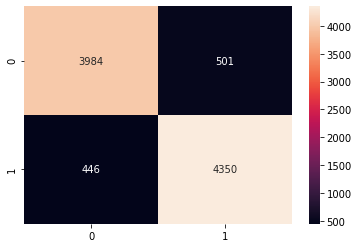

In [37]:
labels =  np.array(svm_cm)
sns.heatmap(svm_cm, annot=labels, fmt = '')
plt.show()

In [38]:
print (metrics.roc_auc_score(y_test, y_pred_svm))

0.8976500762898849


# Random Forest

In [39]:
#Tried depths greater and less than 60, 60 was the best. 
#Tried estimators greater and less than 200 but 200 was the best

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 1)

param_grid = {
    'n_estimators': [200],
    'max_depth': [50, 60, 70]
    }

%time grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
grid_search_rf.fit(x_train, np.ravel(y_train))
grid_search_rf.best_params_

CPU times: user 155 µs, sys: 4 µs, total: 159 µs
Wall time: 165 µs


{'max_depth': 70, 'n_estimators': 200}

In [40]:
y_pred_rf = grid_search_rf.predict(x_test)

In [41]:
print("Accuracy is:", metrics.accuracy_score(y_test, y_pred_rf))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Accuracy is: 0.9306109255468161
Mean Squared Error is: 0.2634180602259153


In [42]:
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print(rf_cm)

[[4072  413]
 [ 231 4565]]


In [43]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4485
           1       0.92      0.95      0.93      4796

    accuracy                           0.93      9281
   macro avg       0.93      0.93      0.93      9281
weighted avg       0.93      0.93      0.93      9281



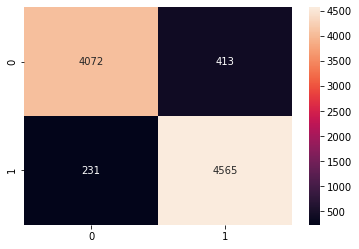

In [44]:
labels = np.array(rf_cm)
sns.heatmap(rf_cm, annot=labels, fmt = '')
plt.show()

In [45]:
# Calculate predicted probabilities for test data 
y_pred_prob_rf = grid_search_rf.predict_proba(x_test)[:, 1]

In [46]:
metrics.roc_auc_score(y_test, y_pred_prob_rf)

0.9775593141069807

<AxesSubplot:>

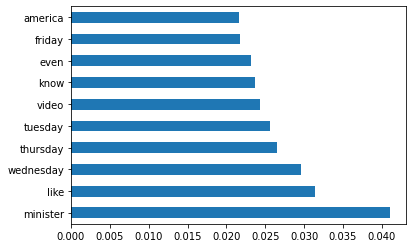

In [47]:
feature_importances = pd.Series(grid_search_rf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importances.nlargest(10).plot(kind='barh')

# Neural Network

In [48]:
import sklearn.model_selection as ms

#Create new train-test set
X = pd.concat([true["text"], fake["text"]])
true["label"] = [0 for x in true["label"]]
fake["label"] = [1 for x in fake["label"]]
y = pd.concat([true["label"], fake["label"]])

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state=1)
train_data = pd.concat([X_train, y_train],axis = 1).reset_index(drop=True)
test_data = pd.concat([X_test, y_test],axis = 1).reset_index(drop=True)

In [49]:
X = pd.DataFrame(X)
articles = X["text"].tolist()
y = pd.DataFrame(y)
labels = y["label"].tolist()

In [50]:
#Create new tokenizer because it's best to tokenize with the same tokenizer 
#that BERT was trained on instead of self-defined one 
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [54]:
# Tokenize all of the articles and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for article in articles:
    encoded_dict = tokenizer.encode_plus(
                        str(article),                      #Article to encode
                        add_special_tokens = True, #Add [CLS] to start, [SEP] to end
                        max_length = 64,           #Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   #Create masks
                        return_tensors = "pt",     # Return pytorch tensors
                   )
    
    #Add the encoded sentence to the list    
    input_ids.append(encoded_dict['input_ids'])
    
    # Add attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0) #encoded sentence
attention_masks = torch.cat(attention_masks, dim=0) #mask
labels = torch.tensor(labels) #labels (fake/true)

In [55]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-10-20 train-validation-test split

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset)) + 1 #add 1 because int() causes 1 row to be left out
test_size = int(0.2 * len(dataset)) 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

32,481 training samples
4,641 validation samples
9,280 test samples


In [56]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#BERT developers recommend 16 or 32 batch_size
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size)

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially, since order doesn't matter here
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially, since order doesn't matter here
            batch_size = batch_size)

In [57]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer  
# Don't output all layers due to memory limits
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab
    num_labels = 2, #binary classification  
    output_attentions = False, 
    output_hidden_states = False)

#run model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [58]:
#Use Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 0.00002,
                  eps = 1e-8) # default is 1e-8

In [59]:
from transformers import get_linear_schedule_with_warmup

# BERT authors recommend between 2 and 4 epochs
epochs = 4

# number of batches x number of epochs
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler to reduce the learning rate as training epochs increase
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, #default
                                            num_training_steps = total_steps)

In [60]:
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return metrics.accuracy_score(pred_flat, labels_flat)

In [61]:
import time
import datetime

#Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [62]:
import random

#Use a seed to ensure reproductibility
seed_val = 22

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device) #copy each tensor to the GPU
        b_input_mask = batch[1].to(device) #copy each tensor to the GPU
        b_labels = batch[2].to(device) #copy each tensor to the GPU

        model.zero_grad()        

        # Perform forward pass 
        # Returns the loss (because we provided labels) and the "logits" - the model
        # outputs prior to activation
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step() # Update the learning rate

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device) #copy each tensor to the GPU
        b_input_mask = batch[1].to(device) #copy each tensor to the GPU
        b_labels = batch[2].to(device) #copy each tensor to the GPU
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)         
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)
        
    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
  Batch    40  of  2,031.    Elapsed: 0:00:06.
  Batch    80  of  2,031.    Elapsed: 0:00:12.
  Batch   120  of  2,031.    Elapsed: 0:00:18.
  Batch   160  of  2,031.    Elapsed: 0:00:24.
  Batch   200  of  2,031.    Elapsed: 0:00:30.
  Batch   240  of  2,031.    Elapsed: 0:00:36.
  Batch   280  of  2,031.    Elapsed: 0:00:42.
  Batch   320  of  2,031.    Elapsed: 0:00:48.
  Batch   360  of  2,031.    Elapsed: 0:00:54.
  Batch   400  of  2,031.    Elapsed: 0:01:00.
  Batch   440  of  2,031.    Elapsed: 0:01:06.
  Batch   480  of  2,031.    Elapsed: 0:01:12.
  Batch   520  of  2,031.    Elapsed: 0:01:18.
  Batch   560  of  2,031.    Elapsed: 0:01:24.
  Batch   600  of  2,031.    Elapsed: 0:01:30.
  Batch   640  of  2,031.    Elapsed: 0:01:36.
  Batch   680  of  2,031.    Elapsed: 0:01:44.
  Batch   720  of  2,031.    Elapsed: 0:01:53.
  Batch   760  of  2,031.    Elapsed: 0:02:10.
  Batch   800  of  2,031.    Elapsed: 0:02:47.
  Batch   840  of  2,031.    

  Batch   520  of  2,031.    Elapsed: 0:13:27.
  Batch   560  of  2,031.    Elapsed: 0:14:24.
  Batch   600  of  2,031.    Elapsed: 0:15:21.
  Batch   640  of  2,031.    Elapsed: 0:16:16.
  Batch   680  of  2,031.    Elapsed: 0:17:12.
  Batch   720  of  2,031.    Elapsed: 0:18:08.
  Batch   760  of  2,031.    Elapsed: 0:19:05.
  Batch   800  of  2,031.    Elapsed: 0:19:58.
  Batch   840  of  2,031.    Elapsed: 0:20:54.
  Batch   880  of  2,031.    Elapsed: 0:21:51.
  Batch   920  of  2,031.    Elapsed: 0:22:46.
  Batch   960  of  2,031.    Elapsed: 0:23:43.
  Batch 1,000  of  2,031.    Elapsed: 0:24:37.
  Batch 1,040  of  2,031.    Elapsed: 0:25:33.
  Batch 1,080  of  2,031.    Elapsed: 0:26:28.
  Batch 1,120  of  2,031.    Elapsed: 0:27:23.
  Batch 1,160  of  2,031.    Elapsed: 0:28:18.
  Batch 1,200  of  2,031.    Elapsed: 0:29:11.
  Batch 1,240  of  2,031.    Elapsed: 0:30:05.
  Batch 1,280  of  2,031.    Elapsed: 0:30:56.
  Batch 1,320  of  2,031.    Elapsed: 0:31:50.
  Batch 1,360

In [63]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.00e-01,0.06,0.99,0:17:48,0:00:56
2,2.84e-02,0.07,0.99,0:24:49,0:01:22
3,9.37e-03,0.08,0.99,0:33:51,0:02:56
4,2.70e-03,0.09,0.99,0:47:27,0:02:00


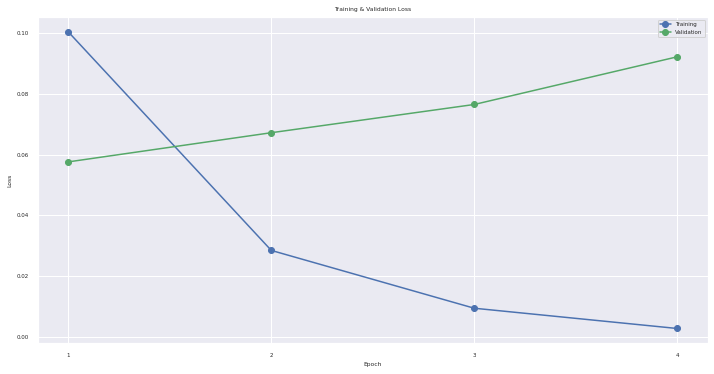

In [64]:
sns.set(style='darkgrid')

sns.set(font_scale=0.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [65]:
model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [66]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

print("Accuracy is:", metrics.accuracy_score(flat_predictions,flat_true_labels))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(flat_predictions, flat_true_labels)))
b_cm = metrics.confusion_matrix(flat_predictions,flat_true_labels)
print(b_cm)

Accuracy is: 0.9927801724137931
Mean Squared Error is: 0.08496956858903602
[[4440   43]
 [  24 4773]]


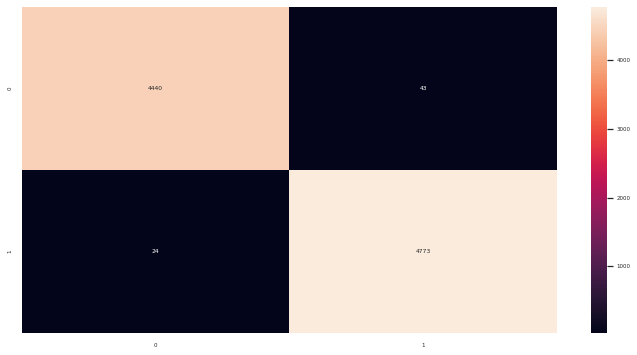

In [67]:
labels = np.array(b_cm)
sns.heatmap(b_cm, annot=labels, fmt = '')
plt.show()

In [69]:
print (metrics.roc_auc_score(flat_predictions, flat_true_labels))
print(metrics.classification_report(flat_predictions, flat_true_labels))

0.9927025409172056
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4483
           1       0.99      0.99      0.99      4797

    accuracy                           0.99      9280
   macro avg       0.99      0.99      0.99      9280
weighted avg       0.99      0.99      0.99      9280

